In [ ]:
%pip install timm

In [1]:
import kaggle
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
import time
import copy
import csv
import os, shutil

from timm.data import Mixup
from timm.loss import SoftTargetCrossEntropy
import timm

In [ ]:
kaggle.api.authenticate()
kaggle.api.dataset_download_files('Dorikan/Airport-Tools-Crops', path='/home/jupyter/datasphere/filestore/datasets/', unzip=True)

!unzip -d /home/jupyter/datasphere/project /home/jupyter/datasphere/filestore/datasets/Airport-Tools-Crops.zip

In [13]:
!rm -f /home/jupyter/datasphere/filestore/datasets/Airport-Tools-Crops.zip
!rm -rf /home/jupyter/datasphere/filestore/datasets/dataset_crops
!mv /home/jupyter/datasphere/project/dataset_crops /home/jupyter/datasphere/filestore/datasets/

In [2]:


class EfficientNetWithEmbeddings(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base = models.efficientnet_b0(pretrained=True)
        self.feature_extractor = self.base.features
        self.pool = self.base.avgpool
        self.embedding_layer = nn.Flatten()
        in_features = self.base.classifier[1].in_features
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x, return_embedding=False):
        x = self.feature_extractor(x)
        x = self.pool(x)
        x = self.embedding_layer(x)
        if return_embedding:
            return x
        out = self.fc(x)
        return out

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 60
batch_size = 128
learning_rate = 1e-3
save_path = '/home/jupyter/datasphere/filestore/training/efficientnet-b0-screwdriver_training'
os.makedirs(save_path, exist_ok=True)

In [4]:
def train_model(model, criterion, optimizer, num_epochs=25, scheduler=None):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    log_file = os.path.join(save_path, "training_log.csv")
    with open(log_file, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        epoch_stats = {}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
                dataloader = train_loader
                transforms = train_transforms
            else:
                model.eval()
                dataloader = valid_loader
                transforms = valid_transforms

            running_loss = 0.0
            running_corrects = 0

            for i, (inputs, labels) in enumerate(dataloader):
                inputs = inputs.to(device)
                inputs = transforms(inputs)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        if scheduler is not None:
                            scheduler.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if i % 10 == 0:
                    done = i * batch_size
                    total = len(dataloader.dataset)
                    print(f"[{phase}] {done}/{total} samples processed...")

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            epoch_stats[f"{phase}_loss"] = epoch_loss
            epoch_stats[f"{phase}_acc"] = epoch_acc.item()

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "valid" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, f"{save_path}/best_model.pth")
                print(">> Saved best model.")

        # Сохраняем лог в CSV
        with open(log_file, mode="a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([epoch+1,
                             epoch_stats["train_loss"], epoch_stats["train_acc"],
                             epoch_stats["valid_loss"], epoch_stats["valid_acc"]])

        # Сохраняем каждые 5 эпох
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f"{save_path}/epoch_{epoch+1}.pth")
            print(f">> Saved checkpoint at epoch {epoch+1}")

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model




In [11]:
train_transforms = torch.nn.Sequential(
    T.RandomRotation(40),
    #T.RandomPerspective(distortion_scale=0.5, p=0.5),
    T.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.7, 1.3), shear=20),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    T.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    #T.RandomGrayscale(p=0.2),
    T.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
    T.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3))
).to(device)

valid_transforms = torch.nn.Sequential(
    T.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
).to(device)



tfs = T.Compose([
    T.RandomResizedCrop(224),   # кроп до 224×224
    T.transforms.ToTensor()
])

In [12]:
train_dataset = datasets.ImageFolder("/home/jupyter/datasphere/filestore/datasets/tmp/train", transform=tfs) #
valid_dataset = datasets.ImageFolder("/home/jupyter/datasphere/filestore/datasets/tmp/valid", transform=tfs) #

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

In [6]:
model = EfficientNetWithEmbeddings(num_classes=3)
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /tmp/xdg_cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 80.3MB/s]


In [ ]:
trained_model = train_model(model, criterion, optimizer, num_epochs=num_epochs)


Epoch 1/60
--------------------
[train] 0/1684 samples processed...
[train] 1280/1684 samples processed...
train Loss: 0.3635 Acc: 0.8397
[valid] 0/439 samples processed...
valid Loss: 0.2831 Acc: 0.9021
>> Saved best model.

Epoch 2/60
--------------------
[train] 0/1684 samples processed...
[train] 1280/1684 samples processed...
train Loss: 0.3417 Acc: 0.8640
[valid] 0/439 samples processed...
valid Loss: 0.3039 Acc: 0.8633

Epoch 3/60
--------------------
[train] 0/1684 samples processed...
[train] 1280/1684 samples processed...
train Loss: 0.3794 Acc: 0.8314
[valid] 0/439 samples processed...
valid Loss: 0.4730 Acc: 0.8109

Epoch 4/60
--------------------
[train] 0/1684 samples processed...
[train] 1280/1684 samples processed...
train Loss: 0.4142 Acc: 0.8284
[valid] 0/439 samples processed...
valid Loss: 0.4104 Acc: 0.8269

Epoch 5/60
--------------------
[train] 0/1684 samples processed...
[train] 1280/1684 samples processed...
train Loss: 0.3023 Acc: 0.8741
[valid] 0/439 sample

In [6]:
state_model = torch.load(os.path.join(save_path, 'best_model.pth'), map_location=torch.device('cpu'))


trained_model = EfficientNetWithEmbeddings(3)
trained_model.load_state_dict(state_model)
trained_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /tmp/xdg_cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 51.9MB/s]


EfficientNetWithEmbeddings(
  (base): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
          

In [9]:
trained_model.to(device)
print()

In [14]:
lrb = 1e-2 * learning_rate
num_epochs = 30
save_path = '/home/jupyter/datasphere/filestore/training/efficientnet-b0_training-screwdriver-backbone'

trained_model.to(device)

for param in trained_model.parameters():
    param.requires_grad = True

optimizer_b = optim.AdamW(model.parameters(), lr=lrb, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

trained_back = train_model(trained_model, criterion, optimizer_b, num_epochs=num_epochs, scheduler=scheduler)


Epoch 1/30
--------------------
[train] 0/1684 samples processed...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[train] 1280/1684 samples processed...
train Loss: 0.2298 Acc: 0.8979
[valid] 0/439 samples processed...
valid Loss: 0.2781 Acc: 0.9180
>> Saved best model.

Epoch 2/30
--------------------
[train] 0/1684 samples processed...
[train] 1280/1684 samples processed...
train Loss: 0.2506 Acc: 0.9074
[valid] 0/439 samples processed...
valid Loss: 0.2991 Acc: 0.8929

Epoch 3/30
--------------------
[train] 0/1684 samples processed...
[train] 1280/1684 samples processed...
train Loss: 0.2227 Acc: 0.9157
[valid] 0/439 samples processed...
valid Loss: 0.3323 Acc: 0.8793

Epoch 4/30
--------------------
[train] 0/1684 samples processed...
[train] 1280/1684 samples processed...
train Loss: 0.2339 Acc: 0.8949
[valid] 0/439 samples processed...
valid Loss: 0.2319 Acc: 0.9226
>> Saved best model.

Epoch 5/30
--------------------
[train] 0/1684 samples processed...
[train] 1280/1684 samples processed...
train Loss: 0.2775 Acc: 0.8895
[valid] 0/439 samples processed...
valid Loss: 0.2673 Acc: 0.9112
>>

In [13]:
trained_back = train_model(trained_back, criterion, optimizer, num_epochs=num_epochs)


Epoch 1/30
--------------------
[train] 0/7582 samples processed...
[train] 1280/7582 samples processed...
[train] 2560/7582 samples processed...
[train] 3840/7582 samples processed...
[train] 5120/7582 samples processed...
[train] 6400/7582 samples processed...
train Loss: 0.1028 Acc: 0.9660
[valid] 0/1997 samples processed...
[valid] 1280/1997 samples processed...
valid Loss: 0.1411 Acc: 0.9609
>> Saved best model.

Epoch 2/30
--------------------
[train] 0/7582 samples processed...
[train] 1280/7582 samples processed...
[train] 2560/7582 samples processed...
[train] 3840/7582 samples processed...
[train] 5120/7582 samples processed...
[train] 6400/7582 samples processed...
train Loss: 0.0973 Acc: 0.9657
[valid] 0/1997 samples processed...
[valid] 1280/1997 samples processed...
valid Loss: 0.1162 Acc: 0.9659
>> Saved best model.

Epoch 3/30
--------------------
[train] 0/7582 samples processed...
[train] 1280/7582 samples processed...
[train] 2560/7582 samples processed...
[train] 3

In [19]:
import pandas as pd
import numpy as np


tfs = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_dataset = datasets.ImageFolder('/home/jupyter/datasphere/filestore/datasets/tmp/test', transform=tfs)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2)

story_df = pd.DataFrame(columns=['cls', 'conf', 'y'])


for i, (inputs, labels) in enumerate(test_loader):
    with torch.no_grad():
        inputs = inputs.to(device)
        labels = labels.to(device)
        logits = trained_back(inputs)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        cls = int(np.argmax(probs))
        conf = float(np.max(probs))
        story_df.loc[i] = {'cls': cls, 'conf': conf, 'y': labels.cpu().numpy()[0]}

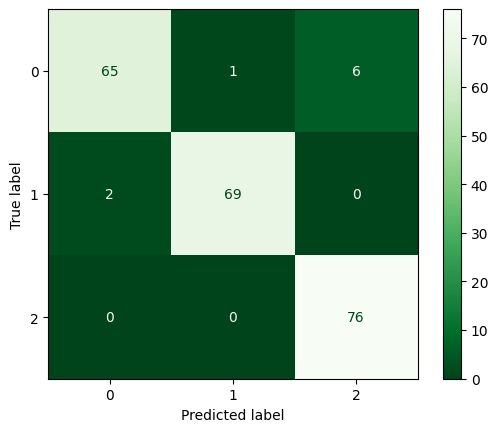

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(story_df.y, story_df.cls)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Greens_r)